
*Note:* You can run this from your computer (Jupyter or terminal), or use one of the
hosted options:

[![binder-logo](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ploomber/binder-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fploomber%252Fprojects%26urlpath%3Dlab%252Ftree%252Fprojects%252Fpython-api%252FREADME.ipynb%26branch%3Dmaster)

[![deepnote-logo](https://deepnote.com/buttons/launch-in-deepnote-small.svg)](https://deepnote.com/launch?template=deepnote&url=https://github.com/ploomber/projects/blob/master/python-api/README.ipynb)



# Python API tutorial

In [1]:
import importlib
from pathlib import Path
from IPython.display import Image, HTML, Markdown, display
from ploomber_basic import pipeline

This example project shows how to use Ploomber's Python API.

Let's imagine you already have a Ploomber pipeline, which is organized in a few tasks. Ploomber allows you to quickly iterate by keeping track of source code changes and skipping unnecessary computations.

Let's first retrieve our pipeline:

In [2]:
dag = pipeline.make()

Plotting it makes easy to understand dependencies between tasks, each node corresponds to one.

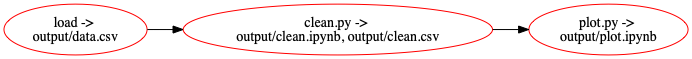

In [3]:
dag.plot()

From the diagram above we can see that running our pipeline will generate a few things:

1. Load task (Python function): CSV file
2. Clean task (Python script):  Jupyter notebook and another CSV file
3. Plot task (Python scripts): Jupyter notebook

*Note: Ploomber allows you to run Python scripts as notebooks but you can execute Jupyter notebooks as well, the output will be a copy of the original notebook.*

The pipeline structure implies that load is a dependency for clean, and clean is a dependency for plot. Given such specification, Ploomber knows that it has to run load, clean and plot, in that order. Furthermore, when clean is executed, Ploomber will automatically insert the output from load at runtime, this ensures that you are running your code with the right inputs (there are no hardcoded paths in any of the tasks).

Let's run it now:

In [4]:
dag.build()

name,Ran?,Elapsed (s),Percentage
load,True,0.014905,0.34522
clean.py,True,1.63647,37.9028
plot.py,True,2.66616,61.7519


You can take a look at the generated output by [clicking here](output/), take a look at the notebooks, they are just like our Python scripts but in Jupyter notebook format, which makes easy to embed tables and plots, while we keep our source code clean in Python scripts.


Let's see what happens if we build again:

In [5]:
dag.build()

name,Ran?,Elapsed (s),Percentage
load,False,0,0
clean.py,False,0,0
plot.py,False,0,0


It didn't run anything! That's because our pipeline has not changed, there is nothing to run. Skipping unnecessary computations can save you a lot of time, especially when tasks take a lot to run. Our example is a simple, linear graph, but Ploomber works even when your pipeline has a lot of tasks with multiple dependencies.

The `dag` object is a fully interactive way of exploring our pipeline. Let's use it to know where our code is located:

In [6]:
# get list of task names
list(dag)

['load', 'clean.py', 'plot.py']

In [7]:
# get task
task = dag['load']

In [8]:
# where is this code declared?
print(task.source.loc)

/Users/Edu/dev/projects-ploomber/python-api/src/ploomber_basic/functions.py:5


Let's modify the code to see how Ploomber handles the change.

For example, replace the line:


```python
df['x'] = df['x'] = 1
```

With:

```python
df['x'] = df['x'] = 42
```


[Click here to open functions.py](src/ploomber_basic/functions.py)

Then come back and run:

In [9]:
dag.build()

name,Ran?,Elapsed (s),Percentage
load,False,0,0
clean.py,False,0,0
plot.py,False,0,0


You should see that all three tasks ran, that's because the load function is the root node. Let's try with another task:

In [10]:
print(dag['clean.py'].source.loc)

/Users/Edu/dev/projects-ploomber/python-api/src/ploomber_basic/notebooks/clean.py


Go ahead and modify the file.

[Click here to open clean.py](src/ploomber_basic/notebooks/clean.py)

Then run:

In [11]:
dag.build()

name,Ran?,Elapsed (s),Percentage
load,False,0,0
clean.py,False,0,0
plot.py,False,0,0


You should see that Ploomber skipped the load task since the clean task is not a dependency.

Ploomber also provides a convenient way to debug tasks. Imagine we found and error in our load step and we want to see what's going on, we can easily do so by starting a debugging session.

Try it out by typing:

```python
dag['load'].debug()
```

in the cell below.


In [12]:
# Remove the comment from the line below, a new prompt will appear
# dag['load'].debug()

Type `n` and press enter to move to the next line, `q` and enter to quit.

**Tip**: Try running `n` once to move to the second line, then `df` to print the data frame contents.

Let's take a look at the actual pipeline declaration, where we'll find a bunch of interesting things.

In [13]:
Markdown("""
```python
{}
```
""".format(Path(pipeline.__file__).read_text()))


```python
import shutil
from pathlib import Path

from ploomber_basic import functions

from ploomber import DAGConfigurator, SourceLoader
from ploomber.tasks import NotebookRunner, PythonCallable
from ploomber.products import File


def make(clean_up=True):
    cfg = DAGConfigurator()
    cfg.params.hot_reload = True
    dag = cfg.create()

    # we will save all output here
    out = Path('output')

    if clean_up and out.exists():
        shutil.rmtree(str(out))

    out.mkdir(exist_ok=True)

    # source loaders allows us to easily load files from modules
    loader = SourceLoader(path='notebooks', module='ploomber_basic')

    # our first task is a Python function, it outputs a csv file
    load = PythonCallable(functions.load,
                          product=File(out / 'data.csv'),
                          dag=dag,
                          name='load')

    # Our second task is a Python script. Since we are using the NotebookRunner
    # task, it will convert it to a Jupyter notebook before execution (you can
    # still pass a .ipynb file). We recommend using .py files as they are
    # easier to merge with git
    clean = NotebookRunner(loader['clean.py'],
                           # this task generates two files, the .ipynb
                           # output notebook and another csv file
                           product={'nb': File(out / 'clean.ipynb'),
                                    'data': File(out / 'clean.csv')},
                           dag=dag,
                           # you can run any language supported by Jupyter
                           # by specifying which kernel to use
                           kernelspec_name='python3',
                           # by enabling this option, a few checks are
                           # performed on your code before running the
                           # notebook. Given that jupyter notebooks are run
                           # cell by cell, something as simple as a syntax
                           # error will be discovered until such cell is run,
                           # this gives you immediate feedback
                           static_analysis=True,
                           papermill_params={'nest_asyncio': True})

    # the final task is also a notebook that generates a plot
    plot = NotebookRunner(loader['plot.py'],
                          File(out / 'plot.ipynb'),
                          dag=dag,
                          kernelspec_name='python3',
                          static_analysis=True,
                          papermill_params={'nest_asyncio': True})

    # declare execution dependencies, by leveraging the graph structure
    # Ploomber can even run tasks in parallel
    load >> clean >> plot

    return dag


if __name__ == '__main__':
    dag = make()
    dag.build()

```


You've made it to the end of this tutorial. Hopefully this will convince you to give it a try in your next project. Ploomber is much more than executing functions and scripts. It also handles SQL scripts pretty well, allows you to test the output of each task, handle configuration settings and much more!

Don't hesitate with any questions you might have. Feel free to [open an issue](https://github.com/ploomber/ploomber/issues/new) in the repository. Thanks for reading!

## Where to go from here

[`ml-advanced/`](../ml-advanced/README.ipynb) contains another example using
the Python API, it shows how to develop a Machine Learning pipeline where tasks
are created dynamycally to train several models.